# Notebook to evaluate optuna HPO studies

In [1]:
import optuna
import pandas as pd
import pandas as pd

#### Define functions to evaluate optuna studies

In [2]:
def load_study(study_name, db_file_path):
    '''
    Load an existing study from a database file
    '''
    return optuna.load_study(study_name=study_name, storage=db_file_path)

def print_best_trial(study):
    trial = study.best_trial
    print(f"Best trial ID: {trial.number}")
    print(f"Best trial value: {trial.value}")
    print("Best parameters:")
    for key, value in trial.params.items():
        print(f"  {key}: {value}")
        
    return trial.number


def trials_dataframe(study):
    '''
    Generate a DataFrame with the data from all trials in a study
    '''
    trial_data = []
    for trial in study.get_trials():
        # Collect trial data
        data = trial.params.copy()
        data['trial_id'] = trial.number
        data['value'] = trial.value
        data['state'] = trial.state.name  # Success, pruned, or failed
        trial_data.append(data)
    df = pd.DataFrame(trial_data)
    return df

### Create results from optuna studies

In [6]:
files = [
        'study-SENTENCE-roberta-base-binary-BiLSTM_[1,2], bio_loss, Median Pruning.db'
        , 'study-SENTENCE-roberta-base-binary-BiLSTM_CRF_[1,2], bio_loss, Median Pruning.db'
        , 'study-SENTENCE-roberta-base-binary-Transformer_[1,2], bio_loss, Median Pruning.db'
]
study_display_names = [
    "Bi-LSTM"
    , "Bi-LSTM+CRF"
    , "Transformer"
]

# files = ["study-TOKEN-roberta-base.db"]
# study_display_names = ["token-level model"]

for file, study_name in zip(files, study_display_names):
    
    file_path = 'sqlite:///../optuna_studies/'+file
    study_names_stored = optuna.study.get_all_study_names(storage=file_path)
    study = load_study(study_names_stored[0], file_path)
    
    print(study_name)
    
    trials = study.get_trials()

    # Extract search space from the first trial
    if trials:
        first_trial = trials[0]
        search_space = first_trial.distributions
        for param_name, distribution in search_space.items():
            print(f"Parameter: {param_name}")
            print(f"Distribution: {distribution}")
    else:
        print("No trials found in the study.")
    

    # Print best trial details
    best_trial = print_best_trial(study)

    # Generate DataFrame with trial details
    df_trials = trials_dataframe(study)[:50]

    # Prepare for latex
    df_trials['HIER_LABELS_LEVELS'] = df_trials['HIER_LABELS_LEVELS'].apply(lambda x: str(x).replace('[', '{[}').replace(']', '{]}').replace('N/A', '\\texttt{N/A}'))
    column_renames = {
        'HIER_LABELS_LEVELS': 'Levels',
        'weight_level_0': '\makecell[l]{Weight\\\\\_level\_0}',
        'weight_level_1': '\makecell[l]{Weight\\\\\_level\_1}',
        'hidden_dim': '\makecell[l]{hidden\\\\\_dim}',
        'nlayers': 'Nlayers',
        'dropout': 'Dropout',
        'alpha': 'Alpha',
        'trial_id': 'Trial\_id',
        'value': 'Value',
        'state': 'State',
        'nhead': 'Nhead',
    }
    df_trials.rename(columns=lambda col: column_renames.get(col, col), inplace=True)
    
    # Define the desired column order
    if "token" in study_name:
        desired_order = [
            'Trial\_id'
            , 'Levels'
            , '\makecell[l]{Weight\\\\\_level\_0}'
            , '\makecell[l]{Weight\\\\\_level\_1}'
            , 'State'
            , 'Value'
        ]
    else:
        desired_order = [
            'Trial\_id'
            , 'Levels'
            , '\makecell[l]{Weight\\\\\_level\_0}'
            , '\makecell[l]{Weight\\\\\_level\_1}'
            , 'Nhead'
            , '\makecell[l]{hidden\\\\\_dim}'
            , 'Nlayers'
            , 'Dropout'
            , 'Alpha'
            , 'State'
            , 'Value'
        ]

    # Reindex DataFrame to match desired order
    df_trials = df_trials.reindex(columns=desired_order)

    # LaTeX table
    latex_table = df_trials.to_latex(index=False, 
                              bold_rows=True, 
                              caption=f"Optuna trials for HPO of {study_name} model.", 
                              label=f"tab:optuna_trials_{study_name}",
                              longtable=False,
                              escape=False,
                              column_format=''.join(['l'] * len(df_trials.columns)),
                              multicolumn=True,
                              multicolumn_format='c',
                              float_format="%.3f",
                              header=True)
    
    # Insert \rowcolor{gray} for best trial row
    lines = latex_table.splitlines()
    for i, line in enumerate(lines):
        if i == best_trial + 7:  # +7 to account for the header and other LaTeX lines before data
            lines[i] = '\\rowcolor[gray]{0.9} ' + line
    latex_table = "\n".join(lines)
    
    latex_table = latex_table.replace("\\begin{table}", "\\begin{table}\n\\footnotesize")
    print(latex_table)
    

Bi-LSTM
Parameter: HIER_LABELS_LEVELS
Distribution: CategoricalDistribution(choices=(None, [1], [2], [1, 2]))
Parameter: weight_level_0
Distribution: FloatDistribution(high=1.0, log=False, low=0.1, step=None)
Parameter: weight_level_1
Distribution: FloatDistribution(high=1.0, log=False, low=0.1, step=None)
Parameter: hidden_dim
Distribution: CategoricalDistribution(choices=(64, 128, 256, 512))
Parameter: nlayers
Distribution: IntDistribution(high=8, log=False, low=1, step=1)
Parameter: dropout
Distribution: FloatDistribution(high=0.5, log=False, low=0.1, step=None)
Parameter: alpha
Distribution: FloatDistribution(high=1.0, log=False, low=0.0, step=None)
Best trial ID: 26
Best trial value: 0.4553340971469879
Best parameters:
  HIER_LABELS_LEVELS: None
  hidden_dim: 256
  nlayers: 5
  dropout: 0.20094464222653943
\begin{table}
\footnotesize
\caption{Optuna trials for HPO of Bi-LSTM model.}
\label{tab:optuna_trials_Bi-LSTM}
\begin{tabular}{lllllllllll}
\toprule
Trial\_id & Levels & \makec

/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: 

Bi-LSTM+CRF
Parameter: HIER_LABELS_LEVELS
Distribution: CategoricalDistribution(choices=(None, [1], [2], [1, 2]))
Parameter: hidden_dim
Distribution: CategoricalDistribution(choices=(64, 128, 256, 512))
Parameter: nlayers
Distribution: IntDistribution(high=8, log=False, low=1, step=1)
Parameter: dropout
Distribution: FloatDistribution(high=0.5, log=False, low=0.1, step=None)
Best trial ID: 4
Best trial value: 0.39292681217193604
Best parameters:
  HIER_LABELS_LEVELS: [1, 2]
  weight_level_0: 0.13536040755789638
  weight_level_1: 0.20001541758119645
  hidden_dim: 512
  nlayers: 3
  dropout: 0.3133391625797591
  alpha: 0.49213810124228363
\begin{table}
\footnotesize
\caption{Optuna trials for HPO of Bi-LSTM+CRF model.}
\label{tab:optuna_trials_Bi-LSTM+CRF}
\begin{tabular}{lllllllllll}
\toprule
Trial\_id & Levels & \makecell[l]{Weight\\\_level\_0} & \makecell[l]{Weight\\\_level\_1} & Nhead & \makecell[l]{hidden\\\_dim} & Nlayers & Dropout & Alpha & State & Value \\
\midrule
0 & None & NaN

/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)


## Visualise parameter importances across multiple studies

/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: 

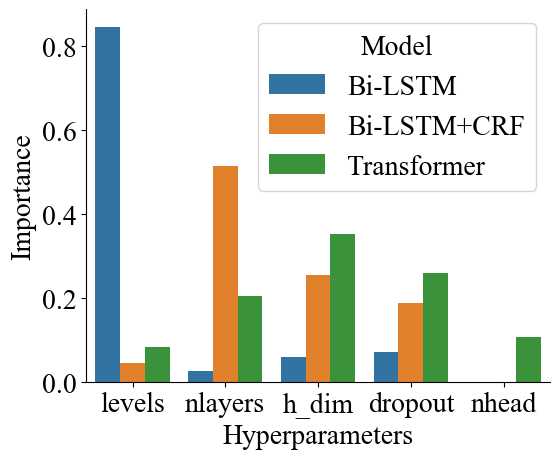

In [7]:
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams

# Set global font to be Times New Roman
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = 'Times New Roman'
rcParams['font.size'] = 20

def plot_hyperparameter_importance(study_files, study_names):
    # Prepare the storage path base
    base_path = 'sqlite:///../optuna_studies/'
    
    # store parameter importances
    all_importances = pd.DataFrame()

    for file, name in zip(study_files, study_names):
        file_path = base_path + file
        study_name_list = optuna.study.get_all_study_names(storage=file_path)
        study = optuna.load_study(study_name=study_name_list[0], storage=file_path)
        
        # Get importances
        importances = optuna.importance.get_param_importances(study)
        
        # Convert importances to DataFrame
        importances_df = pd.DataFrame(list(importances.items()), columns=['parameter', 'importance'])
        importances_df['study'] = name
        importances_df['parameter'] = importances_df['parameter'].replace('HIER_LABELS_LEVELS', 'levels')
        importances_df['parameter'] = importances_df['parameter'].replace('hidden_dim', 'h_dim')
        
        all_importances = pd.concat([all_importances, importances_df], axis=0)

    # Pivot table for grouped bar chart
    pivoted_data = all_importances.pivot_table(index='parameter', columns='study', values='importance').fillna(0)

    # Sort by decreasing importance
    summed_importance = pivoted_data.sum(axis=1).sort_values(ascending=False)
    pivoted_data = pivoted_data.loc[summed_importance.index]

    # Plotting
    plt.figure(figsize=(6, 5))
    sns.set_palette(sns.color_palette())
    sns.barplot(x='parameter', y='importance', hue='study'
                , data=pivoted_data.reset_index().melt(id_vars=['parameter'], var_name='study', value_name='importance'))
    plt.ylabel('Importance')
    plt.xlabel('Hyperparameters')
    plt.legend(title='Model')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()

    # plt.savefig('plots/sentence_HPO_importances.pdf', dpi=300, bbox_inches='tight', pad_inches=0)
    plt.show()
    
plot_hyperparameter_importance(files, study_display_names)


In [9]:
import pandas as pd
import optuna


def generate_latex_table_for_best_trials(study_files, study_names, base_path='sqlite:///../optuna_studies/'):
    rows = []

    # Define column renames
    column_renames = {'HIER_LABELS_LEVELS': 'levels'
                      , 'hidden_dim': 'h\_dim'
                      , 'nhead': 'n\_head'
                      , 'weight_level_0': 'w\_lvl\_0'
                      , 'weight_level_1': 'w\_lvl\_1'}

    for file, study_name in zip(study_files, study_names):
        file_path = base_path + file
        study_name_list = optuna.study.get_all_study_names(storage=file_path)
        study = optuna.load_study(study_name=study_name_list[0], storage=file_path)
        
        best_trial = study.best_trial
        params = {
            column_renames.get(k, k.replace('_', '\\_')): round(v, 2) if isinstance(v, float) else int(v) if isinstance(v, int) else v
            for k, v in best_trial.params.items()
        }

        best_trial_data = {**{'Model': study_name}, **params, **{'Best value': round(best_trial.value, 2)}}
        rows.append(best_trial_data)

    best_trials_summary = pd.DataFrame(rows)

    best_trials_summary.set_index('Model', inplace=True)
    best_trials_summary = best_trials_summary.transpose()

    # Ensure 'Best Value' is last row
    best_value_row = best_trials_summary.loc['Best value']
    best_trials_summary = best_trials_summary.drop(index='Best value')
    best_trials_summary = pd.concat([best_trials_summary, pd.DataFrame(best_value_row).transpose()])

    # Handle NaNs and format directly
    best_trials_summary = best_trials_summary.fillna('N/A')

    # Convert DataFrame to LaTeX code with specific formatting
    latex_code = best_trials_summary.to_latex(index=True, escape=False, longtable=False, column_format='@{}' + 'l' * (len(best_trials_summary.columns) + 1) + '@{}', formatters={col: lambda x: f'{x:.2f}' if isinstance(x, (float)) else x for col in best_trials_summary.columns})

    # Add toprule for separating model names
    lines = latex_code.splitlines()
    header_lines = lines[:4]
    content_lines = lines[4:]

    # Add grey line to separate the 'Best Value'
    for i, line in enumerate(content_lines):
        if 'Best value' in line:
            content_lines.insert(i, "\\rowcolor{gray!20}")
            break

    # Reconstruct LaTeX code
    latex_code = '\n'.join(header_lines + content_lines)
    start_idx = latex_code.index("\\begin{tabular}")
    end_idx = latex_code.index("\\end{tabular}") + len("\\end{tabular}")
    latex_tabular = latex_code[start_idx:end_idx]

    return latex_tabular

study_display_names = [
    "\\makecell[l]{Bi-\\\\LSTM}"
    , "\\makecell[l]{Bi-LSTM\\\\+CRF}"
    , "\\makecell[l]{Trans-\\\\former}"
]

latex_table = generate_latex_table_for_best_trials(files, study_display_names)
print(latex_table)


/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [2] which is of type list.
  warnings.warn(message)
/home/tlh45/rds/hpc-work/clean_repo/.venv/lib64/python3.11/site-packages/optuna/distributions.py:524: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [1, 2] which is of type list.
  warnings.warn(message)


\begin{tabular}{@{}llll@{}}
\toprule
Model & \makecell[l]{Bi-\\LSTM} & \makecell[l]{Bi-LSTM\\+CRF} & \makecell[l]{Trans-\\former} \\
\midrule
levels & N/A & [1, 2] & [1] \\
h\_dim & 256 & 512 & 2048 \\
nlayers & 5 & 3 & 8 \\
dropout & 0.20 & 0.31 & 0.31 \\
w\_lvl\_0 & N/A & 0.14 & 0.55 \\
w\_lvl\_1 & N/A & 0.20 & N/A \\
alpha & N/A & 0.49 & 0.90 \\
n\_head & N/A & N/A & 4.00 \\
\rowcolor{gray!20}
Best value & 0.46 & 0.39 & 0.32 \\
\bottomrule
\end{tabular}
